In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imghdr
import tensorflow as tf
from PIL import Image
import seaborn as sns
tf.random.set_seed(42)

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.applications import VGG16,VGG19, ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import plot_model

In [2]:
base_dir = ''

In [3]:
models_dir = 'models'
models_dir = os.path.join(base_dir, models_dir)

model_names = [
    'Custom_CNN_model',
    'Custom_CNN_Augmentation_model',
    'VGG16_model',
    'VGG19_model',
    'ResNet50_model',
]

for model_name in model_names:
    path = os.path.join(models_dir, model_name)
    os.makedirs(path, exist_ok=True)

In [4]:
def count_img(path, set_type):
    counts = {}
    path = os.path.join(path, set_type)

    for class_name in os.listdir(path):
        class_path =  os.path.join(path, class_name)
        counts[class_name] = len(os.listdir(class_path))
    return counts

In [5]:
data_dir = "data"
data_dir = os.path.join(base_dir, data_dir)

train_counts = count_img(data_dir , 'train')
test_counts = count_img(data_dir , 'test')

print(train_counts)
print(test_counts)

{'angry': 3995, 'disgust': 436, 'fear': 4097, 'happy': 7215, 'neutral': 4965, 'sad': 4830, 'surprise': 3171}
{'angry': 958, 'disgust': 111, 'fear': 1024, 'happy': 1774, 'neutral': 1233, 'sad': 1247, 'surprise': 831}


In [6]:
def plot_counts(emotion_counts, set_type):
    emotions = list(emotion_counts.keys())
    counts = list(emotion_counts.values())

    plt.figure(figsize=(6, 4))
    plt.bar(emotions, counts, color='skyblue')
    plt.xlabel('Emotions')
    plt.ylabel('Count')
    plt.title(set_type)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()

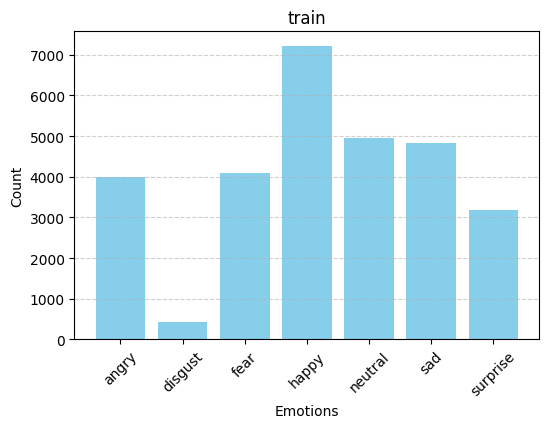

In [7]:
plot_counts(train_counts, 'train')

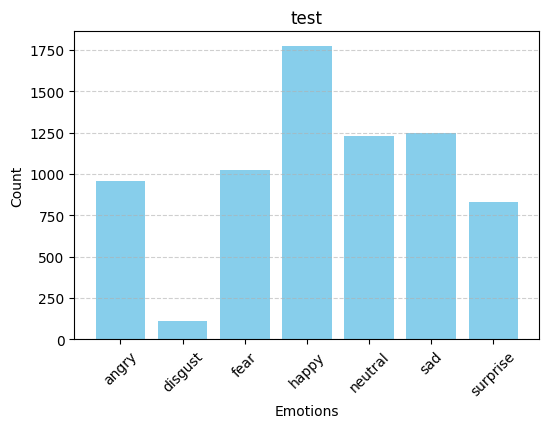

In [8]:
plot_counts(test_counts, 'test')

In [9]:
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

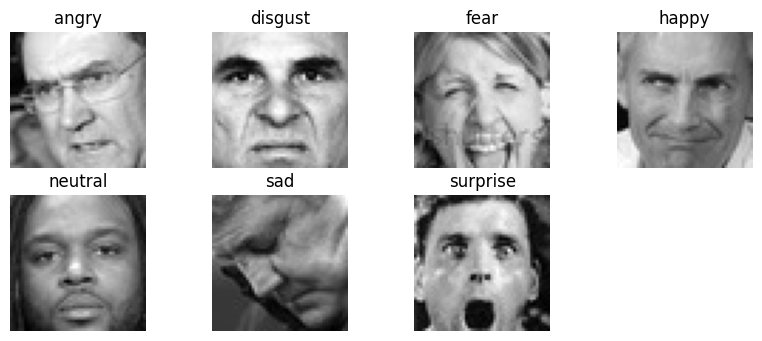

In [10]:
emotions = os.listdir(train_dir)
plt.figure(figsize=(10,6))

for i, emotion in enumerate(emotions, 1):
    folder = os.path.join(train_dir, emotion)
    img_path = os.path.join(folder, os.listdir(folder)[42])
    img = plt.imread(img_path)
    plt.subplot(3, 4, i)
    plt.imshow(img, cmap='gray')
    plt.title(emotion)
    plt.axis('off')

# **1. Custom CNN Model**

In [30]:
img_width, img_height = 48, 48
batch_size = 64
epochs = 50
num_classes = 7

In [31]:
data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = data_generator.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale')

test_generator = data_generator.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [32]:
train_class_labels = train_generator.class_indices
print("Training class labels:", train_class_labels)

test_class_labels = test_generator.class_indices
print("Validation class labels:", test_class_labels)

Training class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Validation class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [33]:
model = Sequential()

model.add(Conv2D(128, kernel_size=(3, 3), padding='same',  activation='relu', input_shape=(img_width, img_height, 1)))
model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.3))

model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.3))

model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(num_classes,activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False),
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 48, 48, 128)       1280      
                                                                 
 conv2d_7 (Conv2D)           (None, 48, 48, 128)       147584    
                                                                 
 batch_normalization_3 (Batc  (None, 48, 48, 128)      512       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 24, 24, 128)      0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 24, 24, 128)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 24, 24, 64)       

In [34]:
cnn_path = os.path.join(models_dir, model_names[0])
name = 'Custom_CNN_model.h5'
chk_path = os.path.join(cnn_path, name)

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='auto',
                             monitor='val_loss')

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=5,
                          verbose=1,
                          restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]

In [35]:
train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

In [37]:
history = model.fit(
    train_generator,
    steps_per_epoch = train_steps_per_epoch,
    epochs = epochs,
    validation_data = test_generator,
    validation_steps = test_steps_epoch,
    callbacks = callbacks
)

Epoch 1/50
449/449 [==============================] - ETA: 0s - loss: 1.9492 - accuracy: 0.2130
Epoch 1: val_loss improved from inf to 1.89640, saving model to models\Custom_CNN_model\Custom_CNN_model.h5
449/449 [==============================] - 22s 47ms/step - loss: 1.9492 - accuracy: 0.2130 - val_loss: 1.8964 - val_accuracy: 0.2491 - lr: 1.0000e-04
Epoch 2/50
449/449 [==============================] - ETA: 0s - loss: 1.8085 - accuracy: 0.2462
Epoch 2: val_loss improved from 1.89640 to 1.76607, saving model to models\Custom_CNN_model\Custom_CNN_model.h5
449/449 [==============================] - 21s 46ms/step - loss: 1.8085 - accuracy: 0.2462 - val_loss: 1.7661 - val_accuracy: 0.2831 - lr: 1.0000e-04
Epoch 3/50
449/449 [==============================] - ETA: 0s - loss: 1.7649 - accuracy: 0.2769
Epoch 3: val_loss improved from 1.76607 to 1.70095, saving model to models\Custom_CNN_model\Custom_CNN_model.h5
449/449 [==============================] - 21s 47ms/step - loss: 1.7649 - accura

In [38]:
def plot_history(history):

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(20, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')


    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

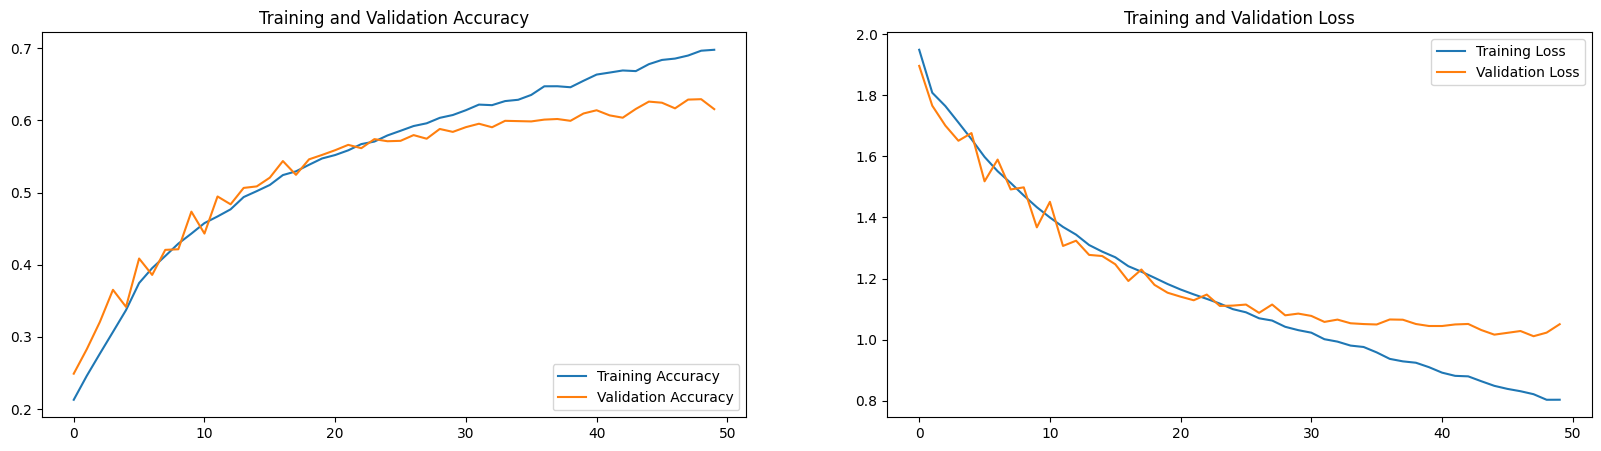

In [39]:
plot_history(history)

## **Model Evaluation**

In [40]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 2s 13ms/step - loss: 1.0504 - accuracy: 0.6155
final train accuracy = 78.37 , validation accuracy = 61.55


## **Confusion Matrix**

113/113 [==============================] - 2s 13ms/step


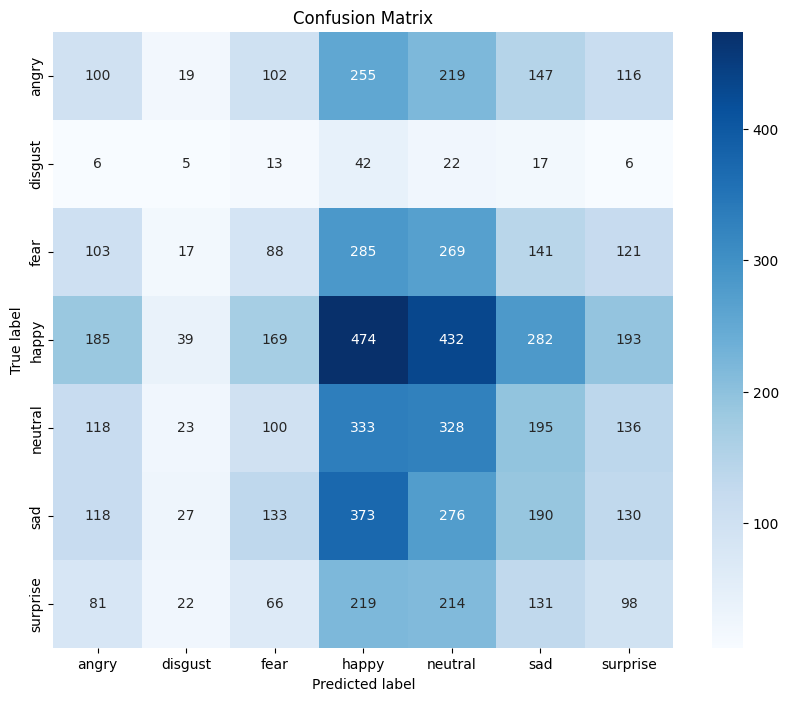

In [41]:
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size)), axis=1)
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## **Classification Report**

In [42]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.14      0.10      0.12       958
     disgust       0.03      0.05      0.04       111
        fear       0.13      0.09      0.10      1024
       happy       0.24      0.27      0.25      1774
     neutral       0.19      0.27      0.22      1233
         sad       0.17      0.15      0.16      1247
    surprise       0.12      0.12      0.12       831

    accuracy                           0.18      7178
   macro avg       0.15      0.15      0.15      7178
weighted avg       0.17      0.18      0.17      7178



## **Prediction**

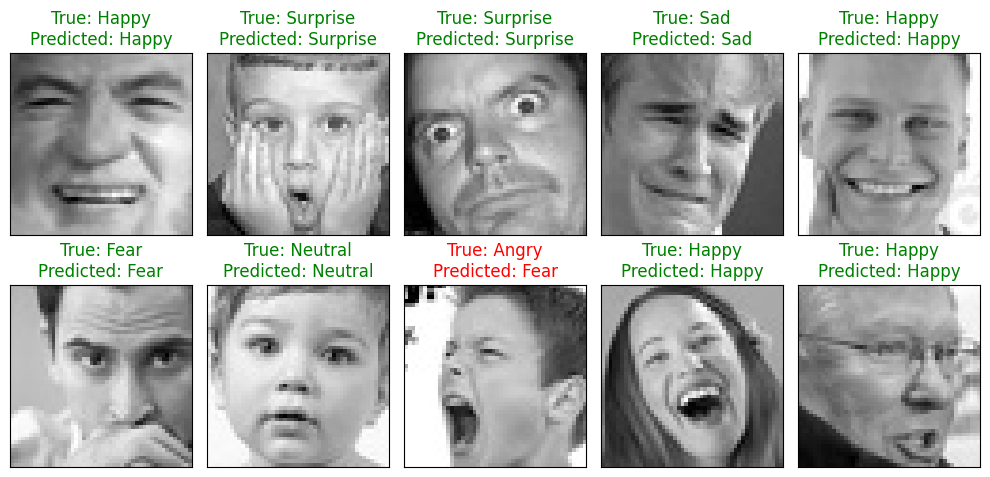

In [43]:
Emotion_Classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

batch_size = test_generator.batch_size

random_batch = np.random.randint(0, len(test_generator) - 1)

random_img_index = np.random.randint(0, batch_size, 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):

    random_img = test_generator[random_batch][0][random_img_index[i]]
    random_img_label = np.argmax(test_generator[random_batch][1][random_img_index[i]], axis=0)

    Model_Prediction = np.argmax(model.predict(tf.expand_dims(random_img, axis=0), verbose=0), axis=1)[0]


    ax.imshow(random_img.squeeze(), cmap='gray')

    color = "green" if Emotion_Classes[random_img_label] == Emotion_Classes[Model_Prediction] else "red"

    ax.set_title(f"True: {Emotion_Classes[random_img_label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)

plt.tight_layout()
plt.show()

# **Model 2 : Custom CNN Model With Augmentation**

In [44]:
img_width, img_height = 48, 48
batch_size = 64
epochs = 50
num_classes = 7


data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

test_data_generator = ImageDataGenerator(rescale=1./255)


train_generator = data_generator.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale')


test_generator = test_data_generator.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
    )

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [45]:
model = Sequential()

model.add(Conv2D(128, kernel_size=(3, 3), padding='same',  activation='relu', input_shape=(img_width, img_height, 1)))
model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.3))

model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.3))

model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))

# Output layer
model.add(Dense(num_classes,activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 48, 48, 128)       1280      
                                                                 
 conv2d_13 (Conv2D)          (None, 48, 48, 128)       147584    
                                                                 
 batch_normalization_6 (Batc  (None, 48, 48, 128)      512       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 24, 24, 128)      0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 24, 24, 128)       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 24, 24, 64)       

In [46]:
cnn_path = os.path.join(models_dir, model_names[1])
name = 'Custom_CNN_Augmentation_model.h5'
chk_path = os.path.join(cnn_path, name)

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='auto',
                             monitor='val_loss')

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=5,
                          verbose=1,
                          restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]

In [47]:
train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

In [48]:
history = model.fit(
    train_generator,
    steps_per_epoch = train_steps_per_epoch,
    epochs = epochs,
    validation_data = test_generator,
    validation_steps = test_steps_epoch,
    callbacks=callbacks
)

Epoch 1/50
449/449 [==============================] - ETA: 0s - loss: 1.9758 - accuracy: 0.2072
Epoch 1: val_loss improved from inf to 1.84822, saving model to models\Custom_CNN_Augmentation_model\Custom_CNN_Augmentation_model.h5
449/449 [==============================] - 22s 48ms/step - loss: 1.9758 - accuracy: 0.2072 - val_loss: 1.8482 - val_accuracy: 0.2471 - lr: 1.0000e-04
Epoch 2/50
449/449 [==============================] - ETA: 0s - loss: 1.8323 - accuracy: 0.2285
Epoch 2: val_loss improved from 1.84822 to 1.80293, saving model to models\Custom_CNN_Augmentation_model\Custom_CNN_Augmentation_model.h5
449/449 [==============================] - 22s 48ms/step - loss: 1.8323 - accuracy: 0.2285 - val_loss: 1.8029 - val_accuracy: 0.2491 - lr: 1.0000e-04
Epoch 3/50
448/449 [============================>.] - ETA: 0s - loss: 1.8169 - accuracy: 0.2339
Epoch 3: val_loss improved from 1.80293 to 1.78946, saving model to models\Custom_CNN_Augmentation_model\Custom_CNN_Augmentation_model.h5
44

In [49]:
def plot_history(history):

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(20, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')


    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

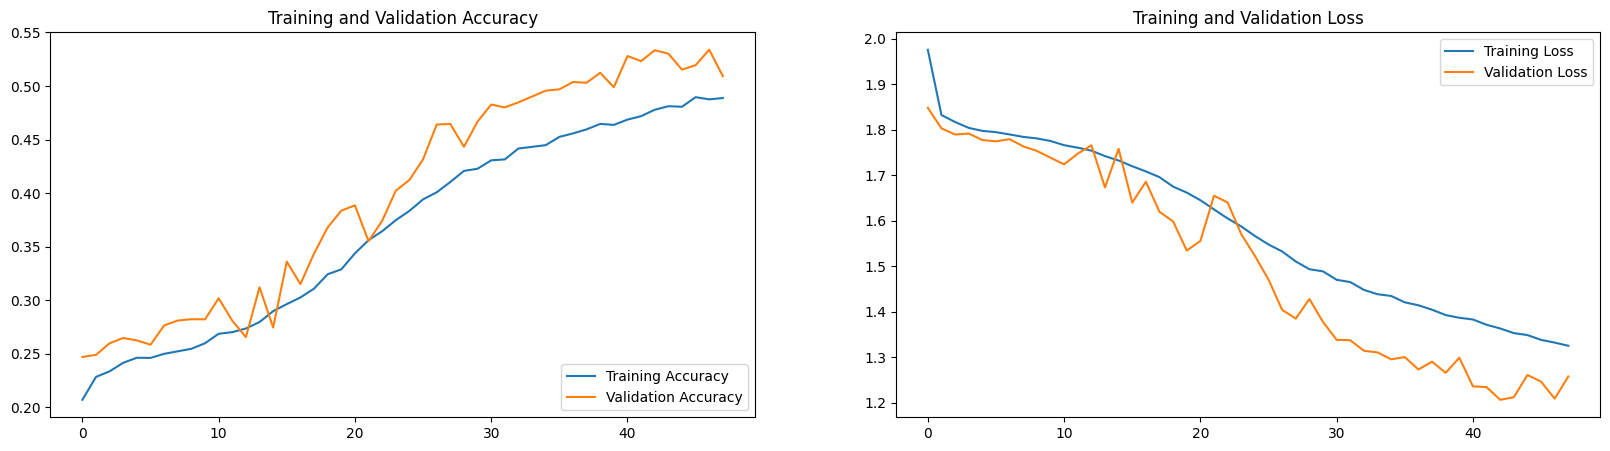

In [50]:
plot_history(history)

## **Model Evaluation**

In [51]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 2s 14ms/step - loss: 1.2060 - accuracy: 0.5334
final train accuracy = 50.18 , validation accuracy = 53.34


## **Confusion Matrix**

113/113 [==============================] - 2s 13ms/step


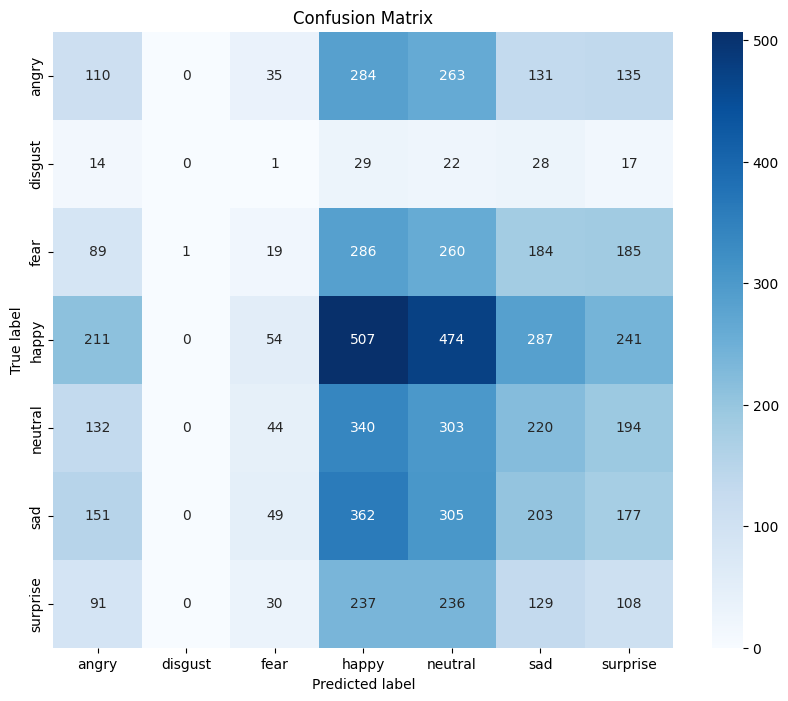

In [52]:
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size)), axis=1)
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## **Classification Report**

In [53]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.14      0.11      0.13       958
     disgust       0.00      0.00      0.00       111
        fear       0.08      0.02      0.03      1024
       happy       0.25      0.29      0.27      1774
     neutral       0.16      0.25      0.20      1233
         sad       0.17      0.16      0.17      1247
    surprise       0.10      0.13      0.11       831

    accuracy                           0.17      7178
   macro avg       0.13      0.14      0.13      7178
weighted avg       0.16      0.17      0.16      7178



## **Prediction**

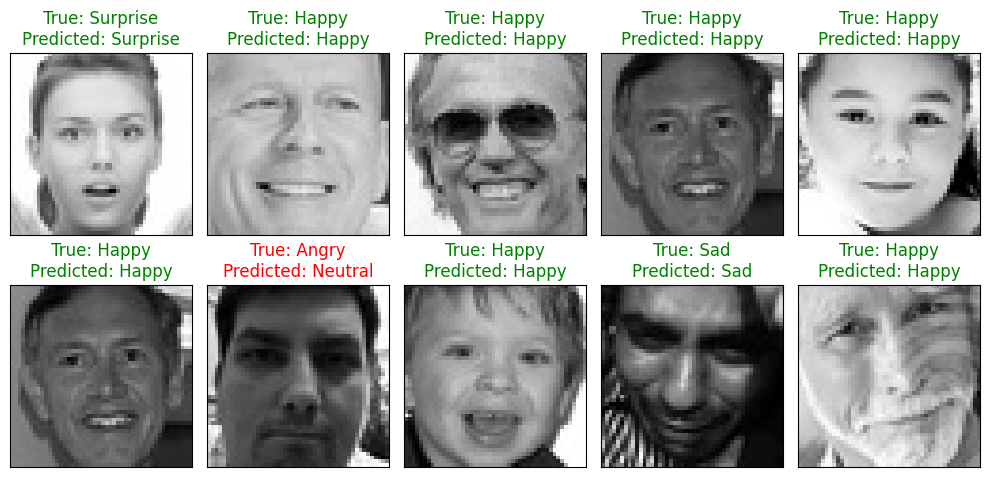

In [54]:
Emotion_Classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

batch_size = test_generator.batch_size

random_batch = np.random.randint(0, len(test_generator) - 1)

random_img_index = np.random.randint(0, batch_size, 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):

    random_img = test_generator[random_batch][0][random_img_index[i]]
    random_img_label = np.argmax(test_generator[random_batch][1][random_img_index[i]], axis=0)

    Model_Prediction = np.argmax(model.predict(tf.expand_dims(random_img, axis=0), verbose=0), axis=1)[0]


    ax.imshow(random_img.squeeze(), cmap='gray')

    color = "green" if Emotion_Classes[random_img_label] == Emotion_Classes[Model_Prediction] else "red"

    ax.set_title(f"True: {Emotion_Classes[random_img_label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)

plt.tight_layout()
plt.show()

## **Model 3 : VGG16**

In [13]:
img_width, img_height = 150, 150
batch_size = 32
epochs = 50
num_classes = 7

data_generator = ImageDataGenerator(
                                rescale = 1 / 255.,
                                rotation_range=10,
                                zoom_range=0.2,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                horizontal_flip=True,
                                fill_mode='nearest',
                                )

test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

train_generator = data_generator.flow_from_directory(
                                train_dir,
                                target_size=(img_width, img_height),
                                batch_size=batch_size,
                                class_mode='categorical',
                                color_mode='rgb',
                                subset='training',
                                shuffle = True)

test_generator = test_preprocessor.flow_from_directory(
                                test_dir,
                                target_size=(img_width, img_height),
                                batch_size=batch_size,
                                class_mode='categorical',
                                shuffle=False,
                                color_mode='rgb',)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [14]:
classes = np.array(train_generator.classes)


class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(classes),
    y=classes
)

class_weights_dict = dict(enumerate(class_weights))

print("Class Weights Dictionary:", class_weights_dict)

Class Weights Dictionary: {0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8260394187886635, 5: 0.8491274770777877, 6: 1.293372978330405}


In [15]:
tf.keras.backend.clear_session()

conv_base = VGG16(input_shape=(img_width, img_height, 3), include_top=False, weights='imagenet')

In [16]:
conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'block4_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

for layer in conv_base.layers:
  print(layer.name,layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 True
block4_conv2 True
block4_conv3 True
block4_pool True
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [17]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [18]:
model = Sequential()

model.add(conv_base)
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Flatten())


model.add(Dense(1024, activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.3))



model.add(Dense(64, activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(num_classes,activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 4, 4, 512)         0         
                                                                 
 batch_normalization (BatchN  (None, 4, 4, 512)        2048      
 ormalization)                                                   
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 1024)              8389632   
                                                                 
 batch_normalization_1 (Batc  (None, 1024)             4096      
 hNormalization)                                        

In [19]:
cnn_path = os.path.join(models_dir, model_names[2])
name = 'VGG16_model.h5'
chk_path = os.path.join(cnn_path, name)

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='auto',
                             monitor='val_loss')

earlystop = EarlyStopping(monitor = 'val_accuracy',
                          min_delta=0,
                          patience=5,
                          verbose=1,
                          restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]

In [20]:
train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

In [21]:
history = model.fit(
                    train_generator,
                    steps_per_epoch=train_steps_per_epoch,
                    epochs=epochs,
                    validation_data=test_generator,
                    validation_steps=test_steps_epoch,
                    class_weight=class_weights_dict,
                    callbacks = callbacks
                    )

Epoch 1/50
898/898 [==============================] - ETA: 0s - loss: 2.0512 - accuracy: 0.1953
Epoch 1: val_loss improved from inf to 1.94911, saving model to models\VGG16_model\VGG16_model.h5
898/898 [==============================] - 278s 292ms/step - loss: 2.0512 - accuracy: 0.1953 - val_loss: 1.9491 - val_accuracy: 0.2314 - lr: 0.0010
Epoch 2/50
898/898 [==============================] - ETA: 0s - loss: 1.8007 - accuracy: 0.2621
Epoch 2: val_loss improved from 1.94911 to 1.63323, saving model to models\VGG16_model\VGG16_model.h5
898/898 [==============================] - 115s 128ms/step - loss: 1.8007 - accuracy: 0.2621 - val_loss: 1.6332 - val_accuracy: 0.3651 - lr: 0.0010
Epoch 3/50
898/898 [==============================] - ETA: 0s - loss: 1.7104 - accuracy: 0.3206
Epoch 3: val_loss did not improve from 1.63323
898/898 [==============================] - 115s 128ms/step - loss: 1.7104 - accuracy: 0.3206 - val_loss: 2.1540 - val_accuracy: 0.3735 - lr: 0.0010
Epoch 4/50
898/898 [=

In [28]:
def plot_history(history):

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(20, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')


    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

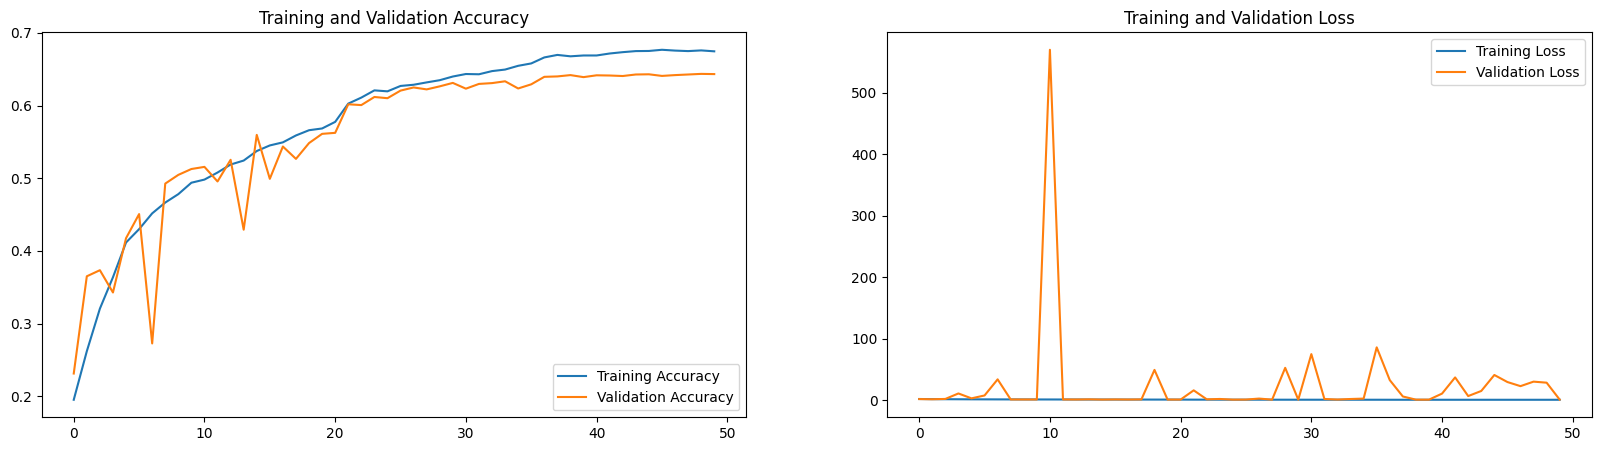

In [29]:
plot_history(history)

## **Model Evaluation**

In [24]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

225/225 [==============================] - 20s 90ms/step - loss: 1.0244 - accuracy: 0.6432
final train accuracy = 69.21 , validation accuracy = 64.32


## **Confusion Matrix**

225/225 [==============================] - 16s 72ms/step


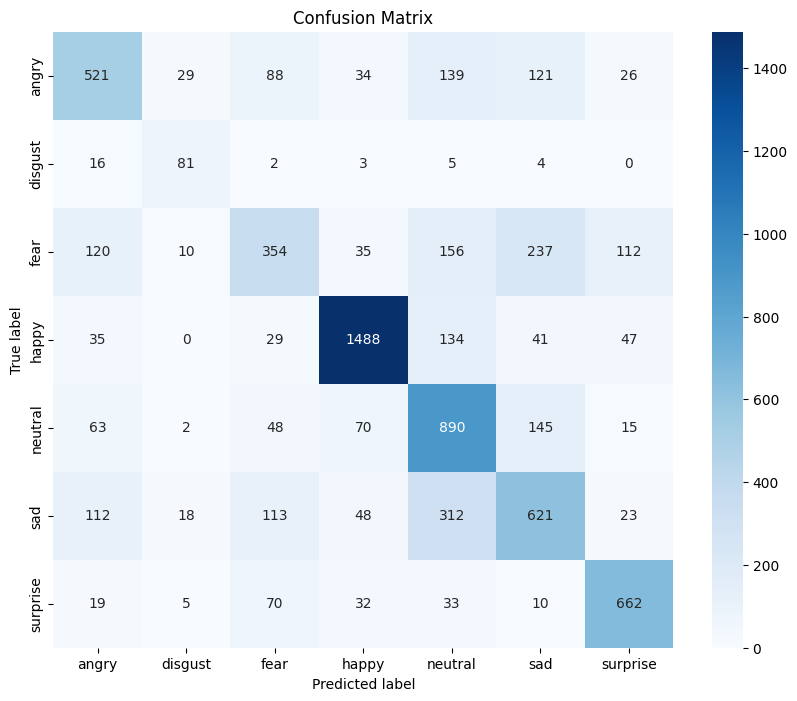

In [25]:
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size)), axis=1)
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## **Classification Report**

In [26]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.59      0.54      0.57       958
     disgust       0.56      0.73      0.63       111
        fear       0.50      0.35      0.41      1024
       happy       0.87      0.84      0.85      1774
     neutral       0.53      0.72      0.61      1233
         sad       0.53      0.50      0.51      1247
    surprise       0.75      0.80      0.77       831

    accuracy                           0.64      7178
   macro avg       0.62      0.64      0.62      7178
weighted avg       0.64      0.64      0.64      7178



## **Prediction**

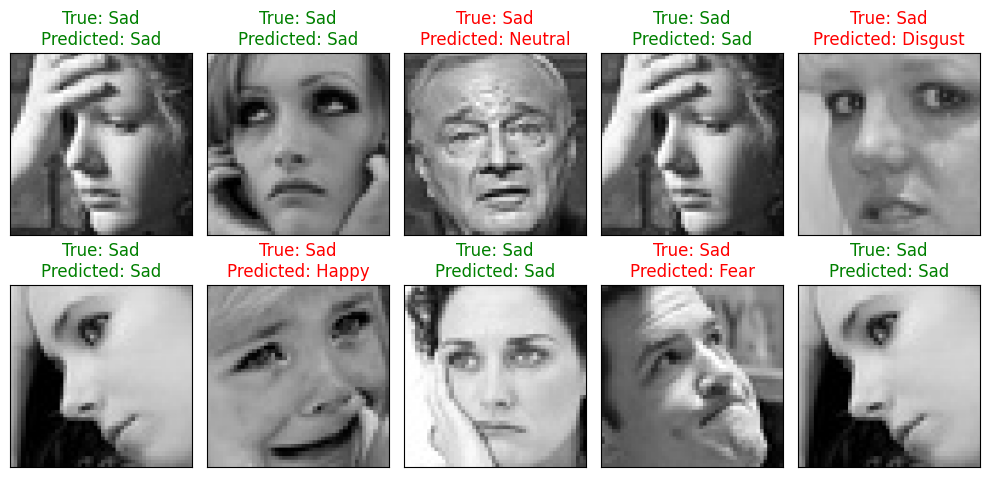

In [27]:
Emotion_Classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

batch_size = test_generator.batch_size

random_batch = np.random.randint(0, len(test_generator) - 1)

random_img_index = np.random.randint(0, batch_size, 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):

    random_img = test_generator[random_batch][0][random_img_index[i]]
    random_img_label = np.argmax(test_generator[random_batch][1][random_img_index[i]], axis=0)

    Model_Prediction = np.argmax(model.predict(tf.expand_dims(random_img, axis=0), verbose=0), axis=1)[0]


    ax.imshow(random_img.squeeze(), cmap='gray')

    color = "green" if Emotion_Classes[random_img_label] == Emotion_Classes[Model_Prediction] else "red"

    ax.set_title(f"True: {Emotion_Classes[random_img_label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)

plt.tight_layout()
plt.show()

## **Model 4: VGG19**

In [40]:
img_width, img_height = 150, 150
batch_size = 32
epochs = 50
num_classes = 7

data_generator = ImageDataGenerator(
                                rescale = 1 / 255.,
                                rotation_range=10,
                                zoom_range=0.2,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                horizontal_flip=True,
                                fill_mode='nearest',
                                )

test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

train_generator = data_generator.flow_from_directory(
                                train_dir,
                                target_size=(img_width, img_height),
                                batch_size=batch_size,
                                class_mode='categorical',
                                color_mode='rgb',
                                subset='training',
                                shuffle = True)

test_generator = test_preprocessor.flow_from_directory(
                                test_dir,
                                target_size=(img_width, img_height),
                                batch_size=batch_size,
                                class_mode='categorical',
                                color_mode='rgb',)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [41]:
conv_base = tf.keras.applications.VGG19(
    weights='imagenet',
    include_top = False,
    input_shape=(img_width, img_height, 3)
)
conv_base.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [42]:
conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

for layer in conv_base.layers:
  print(layer.name,layer.trainable)

input_2 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_conv4 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_conv4 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_conv4 True
block5_pool True


In [43]:
conv_base.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [44]:
model = Sequential()

model.add(conv_base)
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Flatten())

model.add(Dense(1024, activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(64, activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(num_classes,activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 dropout_3 (Dropout)         (None, 4, 4, 512)         0         
                                                                 
 batch_normalization_3 (Batc  (None, 4, 4, 512)        2048      
 hNormalization)                                                 
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_3 (Dense)             (None, 1024)              8389632   
                                                                 
 batch_normalization_4 (Batc  (None, 1024)             4096      
 hNormalization)                                      

In [45]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [46]:
cnn_path = os.path.join(models_dir, model_names[3])
name = 'VGG19_model.h5'
chk_path = os.path.join(cnn_path, name)

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='auto',
                             monitor='val_loss')

earlystop = EarlyStopping(monitor='val_accuracy',
                          min_delta=0,
                          patience=6,
                          verbose=1,
                          restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]

In [47]:
train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

In [48]:
train_history = model.fit(
                          train_generator,
                          steps_per_epoch=train_steps_per_epoch,
                          epochs=epochs,
                          validation_data=test_generator,
                          validation_steps=test_steps_epoch,
                          class_weight=class_weights_dict,
                          callbacks = callbacks
                         )

Epoch 1/50
898/898 [==============================] - ETA: 0s - loss: 2.0099 - accuracy: 0.2006
Epoch 1: val_loss improved from inf to 3.70290, saving model to models\VGG19_model\VGG19_model.h5
898/898 [==============================] - 287s 304ms/step - loss: 2.0099 - accuracy: 0.2006 - val_loss: 3.7029 - val_accuracy: 0.1665 - lr: 0.0010
Epoch 2/50
898/898 [==============================] - ETA: 0s - loss: 1.6984 - accuracy: 0.3313
Epoch 2: val_loss improved from 3.70290 to 1.60281, saving model to models\VGG19_model\VGG19_model.h5
898/898 [==============================] - 96s 107ms/step - loss: 1.6984 - accuracy: 0.3313 - val_loss: 1.6028 - val_accuracy: 0.3668 - lr: 0.0010
Epoch 3/50
898/898 [==============================] - ETA: 0s - loss: 1.5127 - accuracy: 0.4177
Epoch 3: val_loss improved from 1.60281 to 1.50649, saving model to models\VGG19_model\VGG19_model.h5
898/898 [==============================] - 96s 107ms/step - loss: 1.5127 - accuracy: 0.4177 - val_loss: 1.5065 - va

In [51]:
def plot_history(history):

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(20, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')


    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

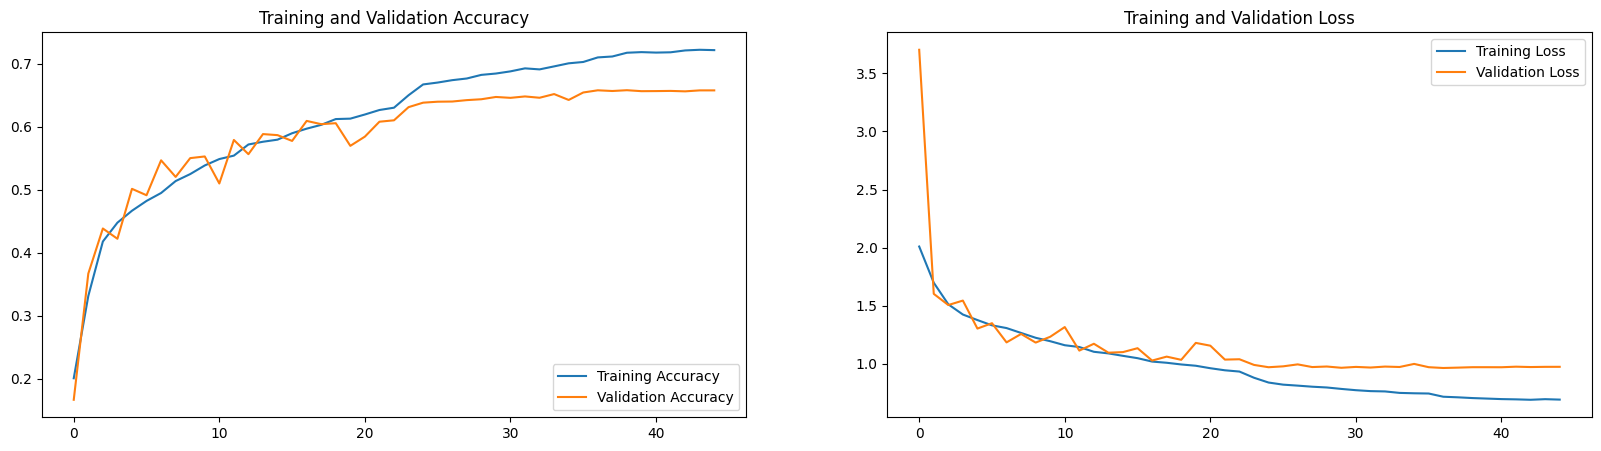

In [53]:
plot_history(train_history)

In [54]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

225/225 [==============================] - 17s 74ms/step - loss: 0.9716 - accuracy: 0.6580
final train accuracy = 73.43 , validation accuracy = 65.80


225/225 [==============================] - 16s 71ms/step


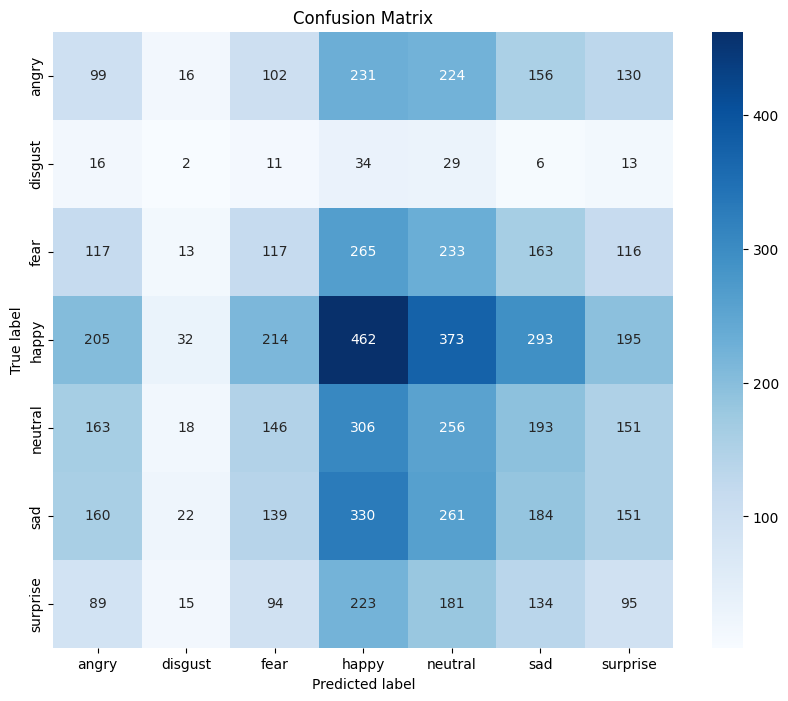

In [55]:
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size)), axis=1)
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [56]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.12      0.10      0.11       958
     disgust       0.02      0.02      0.02       111
        fear       0.14      0.11      0.13      1024
       happy       0.25      0.26      0.25      1774
     neutral       0.16      0.21      0.18      1233
         sad       0.16      0.15      0.15      1247
    surprise       0.11      0.11      0.11       831

    accuracy                           0.17      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.17      0.17      0.17      7178



# **Prediction**

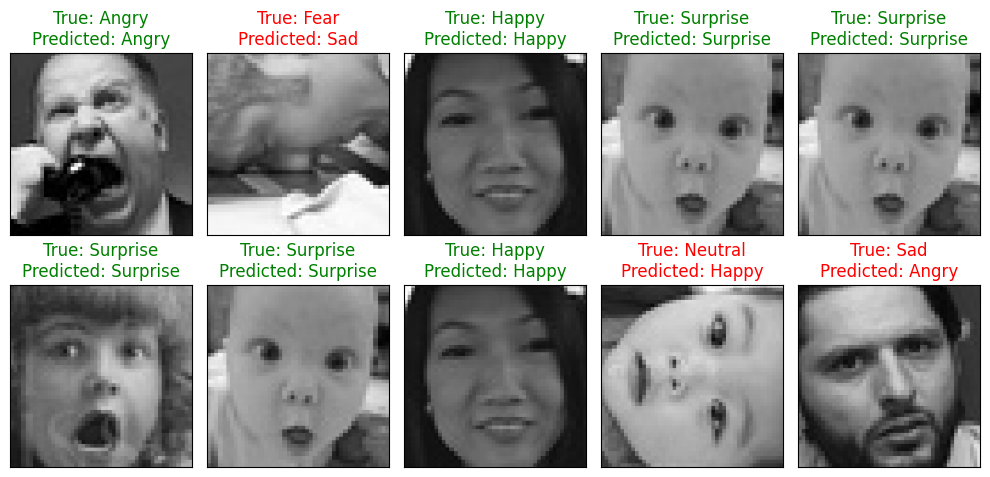

In [57]:
Emotion_Classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

batch_size = test_generator.batch_size

random_batch = np.random.randint(0, len(test_generator) - 1)

random_img_index = np.random.randint(0, batch_size, 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):

    random_img = test_generator[random_batch][0][random_img_index[i]]
    random_img_label = np.argmax(test_generator[random_batch][1][random_img_index[i]], axis=0)

    Model_Prediction = np.argmax(model.predict(tf.expand_dims(random_img, axis=0), verbose=0), axis=1)[0]


    ax.imshow(random_img.squeeze(), cmap='gray')

    color = "green" if Emotion_Classes[random_img_label] == Emotion_Classes[Model_Prediction] else "red"

    ax.set_title(f"True: {Emotion_Classes[random_img_label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)

plt.tight_layout()
plt.show()

# **Model 5: ResNet50**

In [12]:
classes = np.array(train_generator.classes)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(classes),
    y=classes
)


class_weights_dict = dict(enumerate(class_weights))

print("Class Weights Dictionary:", class_weights_dict)

Class Weights Dictionary: {0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8260394187886635, 5: 0.8491274770777877, 6: 1.293372978330405}


In [13]:
conv_base = tf.keras.applications.ResNet50V2(input_shape=(img_width, img_height, 3), include_top= False, weights='imagenet')
conv_base.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 77, 77, 64)   0           ['conv1_conv[0][0]']    

In [14]:
conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
  if 'conv4' in layer.name:
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

for layer in conv_base.layers:
  print(layer.name,layer.trainable)

input_1 False
conv1_pad False
conv1_conv False
pool1_pad False
pool1_pool False
conv2_block1_preact_bn False
conv2_block1_preact_relu False
conv2_block1_1_conv False
conv2_block1_1_bn False
conv2_block1_1_relu False
conv2_block1_2_pad False
conv2_block1_2_conv False
conv2_block1_2_bn False
conv2_block1_2_relu False
conv2_block1_0_conv False
conv2_block1_3_conv False
conv2_block1_out False
conv2_block2_preact_bn False
conv2_block2_preact_relu False
conv2_block2_1_conv False
conv2_block2_1_bn False
conv2_block2_1_relu False
conv2_block2_2_pad False
conv2_block2_2_conv False
conv2_block2_2_bn False
conv2_block2_2_relu False
conv2_block2_3_conv False
conv2_block2_out False
conv2_block3_preact_bn False
conv2_block3_preact_relu False
conv2_block3_1_conv False
conv2_block3_1_bn False
conv2_block3_1_relu False
conv2_block3_2_pad False
conv2_block3_2_conv False
conv2_block3_2_bn False
conv2_block3_2_relu False
max_pooling2d False
conv2_block3_3_conv False
conv2_block3_out False
conv3_block1_pre

In [15]:
conv_base.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 77, 77, 64)   0           ['conv1_conv[0][0]']    

In [16]:
model = Sequential()

model.add(conv_base)
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Flatten())

model.add(Dense(1024, activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(64, activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.3))


model.add(Dense(num_classes,activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 5, 5, 2048)        23564800  
                                                                 
 dropout (Dropout)           (None, 5, 5, 2048)        0         
                                                                 
 batch_normalization (BatchN  (None, 5, 5, 2048)       8192      
 ormalization)                                                   
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 1024)              52429824  
                                                                 
 batch_normalization_1 (Batc  (None, 1024)             4096      
 hNormalization)                                        

In [17]:
cnn_path = os.path.join(models_dir, model_names[4])
name = 'ResNet50_model.h5'
chk_path = os.path.join(cnn_path, name)


checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

earlystop = EarlyStopping(monitor = 'val_accuracy',
                          patience = 7,
                          restore_best_weights = True,
                          verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=2,
                              verbose=1)

csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

callbacks = [checkpoint, earlystop, csv_logger]

In [18]:
train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

In [19]:
history = model.fit(
                          train_generator,
                          steps_per_epoch=train_steps_per_epoch,
                          epochs=epochs,
                          validation_data=test_generator,
                          validation_steps=test_steps_epoch,
                          class_weight=class_weights_dict,
                          callbacks = callbacks
                         )

Epoch 1/100
898/898 [==============================] - ETA: 0s - loss: 1.9360 - accuracy: 0.2791
Epoch 1: val_loss improved from inf to 2.50407, saving model to models\ResNet50_model\ResNet50_model.h5
898/898 [==============================] - 550s 576ms/step - loss: 1.9360 - accuracy: 0.2791 - val_loss: 2.5041 - val_accuracy: 0.1383
Epoch 2/100
898/898 [==============================] - ETA: 0s - loss: 1.6890 - accuracy: 0.3586
Epoch 2: val_loss did not improve from 2.50407
898/898 [==============================] - 130s 144ms/step - loss: 1.6890 - accuracy: 0.3586 - val_loss: 34.8112 - val_accuracy: 0.2101
Epoch 3/100
898/898 [==============================] - ETA: 0s - loss: 1.6262 - accuracy: 0.3885
Epoch 3: val_loss improved from 2.50407 to 1.58848, saving model to models\ResNet50_model\ResNet50_model.h5
898/898 [==============================] - 83s 92ms/step - loss: 1.6262 - accuracy: 0.3885 - val_loss: 1.5885 - val_accuracy: 0.3777
Epoch 4/100
898/898 [=========================

In [20]:
def plot_history(history):

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(20, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')


    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

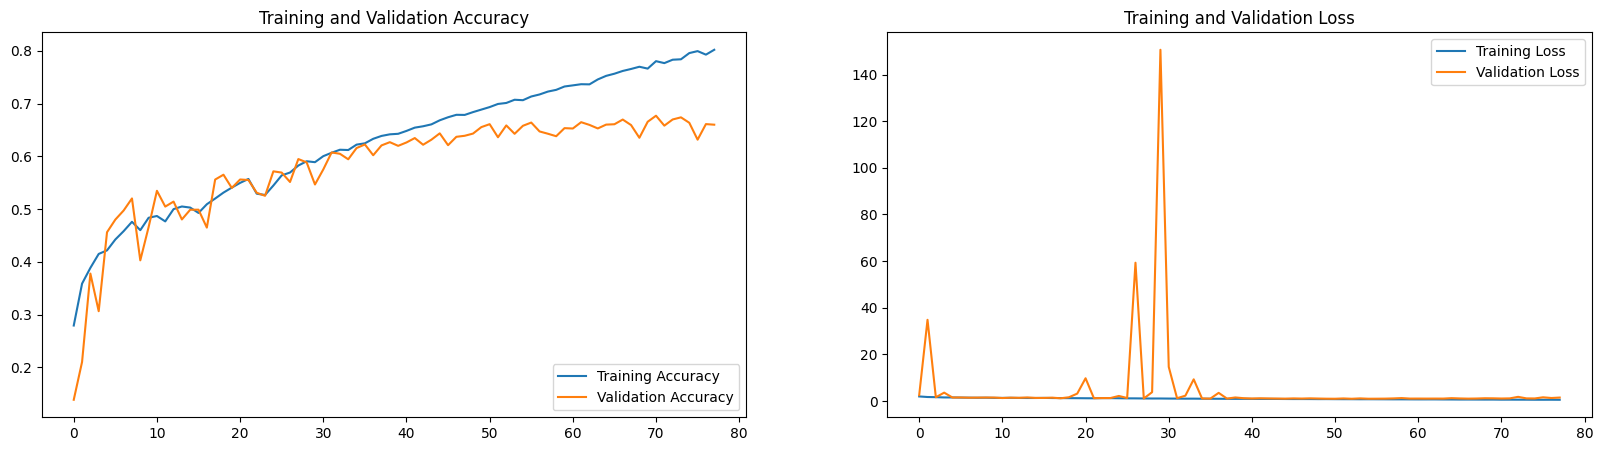

In [21]:
plot_history(history)

In [22]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

225/225 [==============================] - 8s 37ms/step - loss: 1.0462 - accuracy: 0.6771
final train accuracy = 80.40 , validation accuracy = 67.71


225/225 [==============================] - 8s 34ms/step


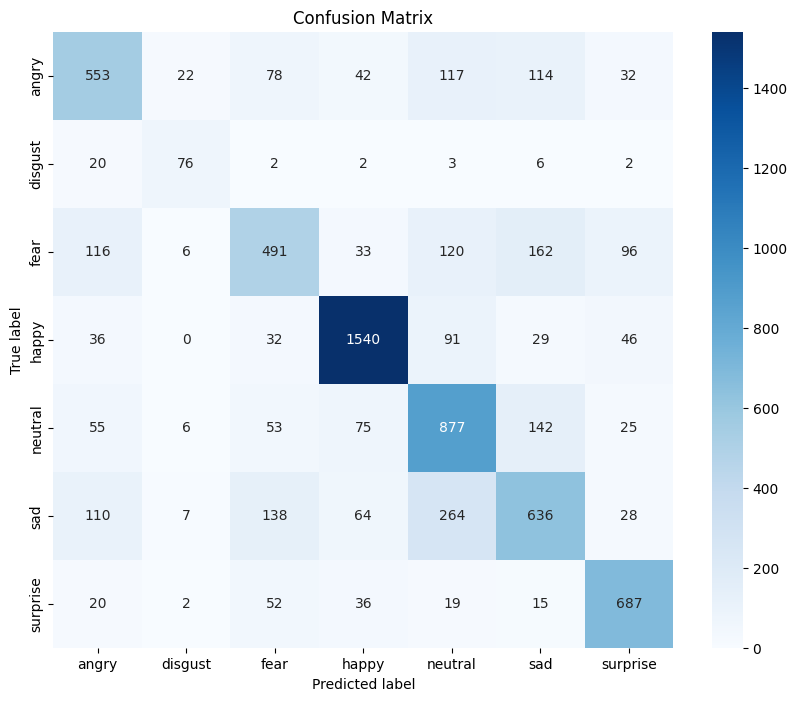

In [23]:
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size)), axis=1)
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [24]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.61      0.58      0.59       958
     disgust       0.64      0.68      0.66       111
        fear       0.58      0.48      0.53      1024
       happy       0.86      0.87      0.86      1774
     neutral       0.59      0.71      0.64      1233
         sad       0.58      0.51      0.54      1247
    surprise       0.75      0.83      0.79       831

    accuracy                           0.68      7178
   macro avg       0.66      0.67      0.66      7178
weighted avg       0.67      0.68      0.67      7178



# **Prediction**

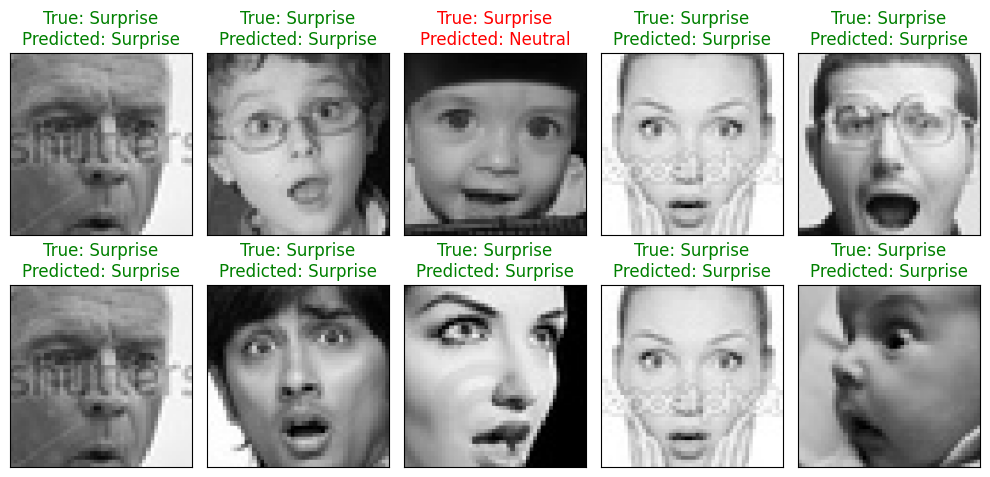

In [25]:
Emotion_Classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

batch_size = test_generator.batch_size

random_batch = np.random.randint(0, len(test_generator) - 1)

random_img_index = np.random.randint(0, batch_size, 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):

    random_img = test_generator[random_batch][0][random_img_index[i]]
    random_img_label = np.argmax(test_generator[random_batch][1][random_img_index[i]], axis=0)

    Model_Prediction = np.argmax(model.predict(tf.expand_dims(random_img, axis=0), verbose=0), axis=1)[0]


    ax.imshow(random_img.squeeze(), cmap='gray')

    color = "green" if Emotion_Classes[random_img_label] == Emotion_Classes[Model_Prediction] else "red"

    ax.set_title(f"True: {Emotion_Classes[random_img_label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)

plt.tight_layout()
plt.show()